# Fouille de données et medias sociaux
# TP4 : Bagging et Boosting

## Exercice 1 Bagging
### Question 1
Écrivez une fonction (ou une classe) implémentant la méthode Bagging.

In [186]:
import numpy as np
from sklearn.base import ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

# TODO: Parallelization
# TODO: Bootstrap on features

class BaggingClassifier(ClassifierMixin):
    def __init__(self, base_estimator=None, n_estimators=5, 
                 max_samples=1.0, bootstrap=True, verbose=0,
                oob_score=False):
        if base_estimator is None:
            self.base_estimator = DecisionTreeClassifier
        else:
            self.base_estimator = base_estimator
            
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.bootstrap = bootstrap
        self.verbose = verbose
        self.oob_score = oob_score
        
        
        self.estimators = None
        self.oob_score_ = None
        
    def fit(self, X, y):
        self.estimators = []
        if self.oob_score:
            self.oob_counters = [Counter() for elt in X]
            # self.oob_counters[i] = predictions for sample i
        if self.verbose >= 1:
            print("##### Fitting the classifiers #####")
        for i in range(self.n_estimators):
            if self.verbose >= 1:
                print("Fitting classifier n°%d..." % i)
            clf = self.base_estimator()
            sample_idx = np.random.choice(X.shape[0], 
                                          int(X.shape[0]*self.max_samples), 
                                          replace=self.bootstrap)
            if self.verbose >= 2:
                print("Random indexes:", sample_idx)
            clf.fit(X[sample_idx], y[sample_idx])
            if self.verbose >= 1:
                print("Done.")
            
            if self.oob_score:
                oob_samples = np.setdiff1d(np.arange(X.shape[0]), sample_idx)
                preds = clf.predict(X)
                for i in oob_samples:
                    self.oob_counters[i].update([preds[i]])
                    
            self.estimators.append(clf)
          
        if self.oob_score:
            if Counter() in self.oob_counters:
                print("Warning, some samples don't have OOB estimations, \
                        the number of estimators seems to be too low.")
            else:
                self.oob_predictions = [c.most_common(1)[0][0] for c in self.oob_counters]
                errors = np.count_nonzero(self.oob_predictions != y)
                self.oob_score_ = errors / X.shape[0]
        
        if self.verbose >= 1:
            print("##### Fitting is over #####")
        
    def predict(self, X):
        predictions = np.empty((X.shape[0], len(self.estimators)))
        # predictions[i][j] = self.estimators[j].predict(X[i])
        # TODO: More efficient method: only store new class and counters
        for j, clf in enumerate(self.estimators):
            predictions[:, j] = clf.predict(X)
        
        most_common = [Counter(line).most_common(1)[0][0] for line in predictions]
        return most_common
        
    def score(self, X, y):
        return accuracy_score(self.predict(X), y)
    
    
    

### Question 2
Appliquez cette méthode sur des arbres de décisions.

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV

iris = datasets.load_iris()
X, y = iris.data, iris.target

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Classes in y:", np.unique(y, return_counts=True))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

bag_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier, oob_score=True,
                            n_estimators=100, verbose=0)
bag_clf.fit(X_train, y_train)
print("Scores with bag_clf:", bag_clf.score(X_test, y_test))



Shape of X: (150, 4)
Shape of y: (150,)
Classes in y: (array([0, 1, 2]), array([50, 50, 50]))
Scores with bag_clf: 0.955555555556


### Question 3
Évaluez et commentez l’erreur en généralisation par rapport à un arbre unique.

In [3]:
print("For the BaggingClassifier, OOB error:", bag_clf.oob_score_)

# Evaluating the OOB error on a decision tree:

# Parameters for the Grid Search:
params = {"criterion":("gini", "entropy"),
          "splitter":("best", "random"),
          "max_depth":np.arange(5, 51, 5),
          "min_samples_split":np.linspace(1e-3, 1., 5)
            }

gridsearch = GridSearchCV(DecisionTreeClassifier(), params)
gridsearch.fit(X_train, y_train)

print("For the DecisionTreeClassifier, OOB error:", 1 - gridsearch.score(X_test, y_test))
print("Best parameters found for the DecisionTreeClassifier:", gridsearch.best_params_)

For the BaggingClassifier, OOB error: 0.05714285714285714
For the DecisionTreeClassifier, OOB error: 0.0444444444444
Best parameters found for the DecisionTreeClassifier: {'splitter': 'random', 'criterion': 'entropy', 'min_samples_split': 0.25074999999999997, 'max_depth': 35}


## Exercice 2 Boosting
### Question 1
**Montrer que le coefficient de pondération des hypothèses vaut bien ce qu’il vaut.**

Soit un problème d'apprentissage avec $((x_i, y_i)_{i \in \{1..n\}}$, $x_i \in X$, $y_i \in \{-1, +1\}$

Après l'itération n° $m-1$, notre classifieur Boost est une combinaison linéaire de classifieurs faibles $h_i:X \rightarrow \{-1, +1\}$ pondéré par les coefficients $a_i$:

$C_{m-1}(x) = \sum_{i=1}^{m-1}{a_i ⋅ h_i(x)}$.

On veut trouver un nouvel estimateur faible $h_m$ pour avoir l'estimateur Boost à l'itération $m$.

Soit l'erreur totale de $C_m$ : $E = \sum_{i=1}^n{e^{-y_i ⋅ C_m(x_i)}}$, 

posons $w_i^1 = 1$ et $w_i^m = e^{-y_i ⋅ C_{m-1}(x_i)}$ pour $1 < m$, 
on a alors :

$E = \sum_{i=1}^n{e^{-y_i ⋅ C_m(x_i)}} \\
E = \sum_{y_i = h_m(x_i)}{w_i^m⋅e^{-a_m}} + \sum_{y_i \neq h_m(x_i)}{w_i^m⋅e^{a_m}} \\
E = \sum_{i=1}^n{w_i^m ⋅ e^{-a_m}} + \sum_{y_i \neq h_m(x_i)}{w_i^m⋅(e^{a_m} - e^{-a_m})} $

Ainsi l'estimateur faible $h_m$ qui minimise $E$ est celui qui minimise $\sum_{y_i \neq h_m(x_i)}{w_i^m}$, c'est-à-dire le classifieur qui fait le moins d'erreurs de classification, avec la pondération $w_i^m$.

Après avoir trouvé ce classifieur $h_m$, il faut trouver le coefficient $a_m$, c'est le coefficient qui minimise $E$ :

$\frac {dE}{da_m} = \sum_{y_i \neq h_m(x_i)}{w_i^m⋅e^{a_m}} - \sum_{y_i = h_m(x_i)}{w_i^m⋅e^{-a_m}}$

$\frac {dE}{da_m} = 0 \Leftrightarrow \sum_{y_i \neq h_m(x_i)}{w_i^m⋅e^{a_m}} - \sum_{y_i = h_m(x_i)}{w_i^m⋅e^{-a_m}} = 0 \\
\Leftrightarrow \sum_{y_i \neq h_m(x_i)}{w_i^m⋅e^{a_m}}  = \sum_{y_i = h_m(x_i)}{w_i^m⋅e^{-a_m}}\\
\Leftrightarrow e^{2⋅a_m}⋅\sum_{y_i \neq h_m(x_i)}{w_i^m}  = \sum_{y_i = h_m(x_i)}{w_i^m}\\
\Leftrightarrow 2⋅a_m = ln(\frac {\sum_{y_i = h_m(x_i)}{w_i^m}}{\sum_{y_i \neq h_m(x_i)}{w_i^m} })\\
\Leftrightarrow a_m = \frac 1 2 ln(\frac {\sum_{y_i = h_m(x_i)}{w_i^m}}{\sum_{y_i \neq h_m(x_i)}{w_i^m} })$

Ainsi on peut écrire l'erreur pondérée : 

$\epsilon_m = \frac {\sum_{y_i \neq h_m(x_i)}{w_i^m}} {\sum_{i=1}^n{w_i^m}}$

Et donc $a_m = \frac 1 2 ln(\frac {1-\epsilon_m} {\epsilon_m})$

### Question 2
Écrivez une fonction (ou une classe) implémentant la méthode AdaBoost.

In [206]:
from sklearn.base import clone

class AdaBoostClassifier(ClassifierMixin):
    
    def __init__(self, base_estimator=None, n_estimators=50, learning_rate=1, verbose=False):
        """ Create an AdaBoostClassifier.
        :param base_estimator: The estimator used to fit the data. 
            Support for sample weighting is required
        :param n_estimators: Number of used estimators"""
        if base_estimator is None:
            self.base_estimator = DecisionTreeClassifier()
        else:
            self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.verbose = verbose

    def fit(self, X, y):
        sample_weight = np.array([1/y.shape[0]] * y.shape[0])
        self.estimators = []
        self.alphas = []
        for it in range(self.n_estimators):
            clf = clone(self.base_estimator)
            clf.fit(X, y, sample_weight=sample_weight)
            prediction = clf.predict(X)
            misclass = np.arange(y.shape[0])[prediction != y]
            error = sum(sample_weight[misclass])
            
            if error == 0:
                error = 1/y.shape[0]
            alpha = 1/2 * np.log((1-error)/error)
            if self.verbose:
                print(20*'-')
                print("Weights:", sample_weight[:20])
                print("Misclassified:", misclass[:10])
                print("Summed error: %f, score: %f (%d misclassified)" %(error, 1-error, len(misclass)))
                print("Alpha:", alpha)
#                 print("Feature importance:", clf.feature_importances_)
                print(20*'-')
            sample_weight = sample_weight * np.exp(-y * prediction * alpha)
            sample_weight /= sum(sample_weight)
            self.estimators.append(clf)
            self.alphas.append(alpha)
            
    def predict(self, X):
        predictions = np.zeros(X.shape[0])
        for clf, alpha in zip(self.estimators, self.alphas):
            if self.verbose:
                print(clf.predict(X)[:10])
            predictions += alpha * self.learning_rate * clf.predict(X)
            
        return np.sign(predictions)


# Testing:
print("##### Extracting the data #####")
breast_cancer = datasets.load_breast_cancer()
X, y = breast_cancer.data, breast_cancer.target

y = (y*2) - 1 # To bring y into {-1, +1}
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Classes in y:", np.unique(y, return_counts=True))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

        
print("##### Testing AdaBoost: #####")
np.set_printoptions(precision=4)
adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), 
                              learning_rate=1,
                              n_estimators=5, verbose=False)
adaboost.fit(X_train, y_train)
print("Score on the test set:", accuracy_score(adaboost.predict(X_test), y_test))

            

##### Extracting the data #####
Shape of X: (569, 30)
Shape of y: (569,)
Classes in y: (array([-1,  1]), array([212, 357]))
##### Testing AdaBoost: #####
Score on the test set: 0.947368421053


### Question 3
Comment adapter un classifieur qui ne gère pas naturellement des pondérations pour qu’il puisse en tenir
compte ?
### Question 4
Appliquez cette méthode sur des stumps (arbres de décision à un nœud).

##### Finding the score of one stump #####
Stump score: 0.906432748538
##### Finding the score of a tree #####
Tree score: 0.93567251462
Finding n_estimators


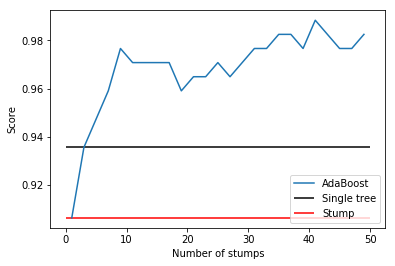

In [224]:
import matplotlib.pyplot as plt

print("##### Finding the score of one stump #####")
stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)
stump_score = stump.score(X_test, y_test)
print("Stump score:", stump_score)

print("##### Finding the score of a tree #####")
gridsearch = GridSearchCV(DecisionTreeClassifier(), 
                          param_grid={'max_depth':np.logspace(0.1, 2, 10, dtype=int),
                                     'splitter':("best", "random")})
gridsearch.fit(X_train, y_train)
tree_score = gridsearch.score(X_test, y_test)
print("Tree score:", tree_score)


print("Finding n_estimators")
max_estimators = 50
n_estimators_list = range(1, max_estimators, 2)
scores_list = []
for n_estimators in n_estimators_list:
    adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                  learning_rate=1,
                                  n_estimators=n_estimators)
    adaboost.fit(X_train, y_train)
    scores_list.append(accuracy_score(adaboost.predict(X_test), y_test))

# print(n_estimators_list)
# print(scores_list)
plt.plot(n_estimators_list, scores_list, label="AdaBoost")
plt.hlines(tree_score, xmin=0, xmax=max_estimators, label="Single tree", colors="black")
plt.hlines(stump_score, xmin=0, xmax=max_estimators, label="Stump", colors="r")
plt.xlabel("Number of stumps")
plt.ylabel("Score")
plt.legend()
plt.show()

### Question 5
Tracez les courbes de l’erreur d’apprentissage et de l’erreur de test en fonction du nombre de classifieurs.
1
### Question 6
Affichez les points associés aux poids les plus élevés (donc les plus difficiles à classer). Sont-ils bien classés
désormais ? Étaient-ils bien classé avec un seul arbre de décision ? Avec le Bagging ?
### Question 7
Appliquez AdaBoost à des arbres de décision de profondeur plus grande.
Comment se comporte la généralisation quand la profondeur des arbres augmente ?